In [1]:
import pandas as pd

remove team names and referee names  


In [2]:
# load in our data
cleaned_15_24 = pd.read_csv("Premier League 2015-2024.csv")
cleaned_15_24['Date'] = pd.to_datetime(cleaned_15_24['Date'], format='%d/%m/%Y')
print(cleaned_15_24.head())

cleaned_24_25 = pd.read_csv("24-25 Season.csv")
cleaned_24_25['Date'] = pd.to_datetime(cleaned_24_25['Date'], format='%d/%m/%Y')
print(cleaned_24_25.head())

        Date     HomeTeam     AwayTeam FTR  HTHG  HTAG HTR        Referee  HS  \
0 2015-08-08  Bournemouth  Aston Villa   A     0     0   D  M Clattenburg  11   
1 2015-08-08      Chelsea      Swansea   D     2     1   H       M Oliver  11   
2 2015-08-08      Everton      Watford   D     0     1   A        M Jones  10   
3 2015-08-08    Leicester   Sunderland   H     3     0   H        L Mason  19   
4 2015-08-08   Man United    Tottenham   H     1     0   H         J Moss   9   

   AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  
0   7    2    3  13  13   6   3   3   4   0   0  
1  18    3   10  15  16   4   8   1   3   1   0  
2  11    5    5   7  13   8   2   1   2   0   0  
3  10    8    5  13  17   6   3   2   4   0   0  
4   9    1    4  12  12   1   2   2   3   0   0  
        Date    HomeTeam     AwayTeam FTR  HTHG  HTAG HTR     Referee  HS  AS  \
0 2024-08-16  Man United       Fulham   H     0     0   D     R Jones  14  10   
1 2024-08-17     Ipswich    Liverpool   A     0    

Date = Match Date (dd/mm/yy) [numeric]  
HomeTeam = Home Team [categorical]  
AwayTeam = Away Team [categorical]  
FTR and Res = Full Time Result (H=Home Win, D=Draw, A=Away Win) [categorical]  
HTHG = Half Time Home Team Goals [numeric]  
HTAG = Half Time Away Team Goals [numeric]  
HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win) [categorical]  
Referee = Match Referee [categorical]  
HS = Home Team Shots [numeric]  
AS = Away Team Shots [numeric]  
HST = Home Team Shots on Target [numeric]  
AST = Away Team Shots on Target [numeric]  
HF = Home Team Fouls Committed [numeric]  
AF = Away Team Fouls Committed [numeric]  
HC = Home Team Corners [numeric]  
AC = Away Team Corners [numeric]  
HY = Home Team Yellow Cards [numeric]  
AY = Away Team Yellow Cards [numeric]  
HR = Home Team Red Cards [numeric]  
AR = Away Team Red Cards [numeric]  

In [3]:
numeric_cols = ['HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
categorical_cols = ['HomeTeam', 'AwayTeam', 'Referee']

In [4]:
# first we shall try to predict with all of our faatures (so full time and half time data) and 2015 - 2024 will be our testing data
# and then 24-25 will be our testing data
training_csv = cleaned_15_24
testing_csv = cleaned_24_25

# first let us plot the distribution of wins so that we can make sure the distribution is equal between both classes
def find_proportions(data):
    total = len(data)
    home_wins = (data["FTR"] == 'H').sum()
    away_wins = (data["FTR"] == 'A').sum()
    draws = (data["FTR"] == 'D').sum()

    return {
        "Home wins" : (home_wins, home_wins / total),
        "Away wins" : (away_wins, away_wins / total),
        "Draws" : (draws, draws / total)
    }

print(find_proportions(training_csv))
print(find_proportions(testing_csv))

{'Home wins': (np.int64(1536), np.float64(0.44912280701754387)), 'Away wins': (np.int64(1091), np.float64(0.31900584795321635)), 'Draws': (np.int64(793), np.float64(0.23187134502923976))}
{'Home wins': (np.int64(107), np.float64(0.3948339483394834)), 'Away wins': (np.int64(97), np.float64(0.35793357933579334)), 'Draws': (np.int64(67), np.float64(0.24723247232472326))}


Honestly I would think that the proportions are pretty similar so I won't do any processing on that just yet, maybe down the line if the data looks wonky or something I will change it

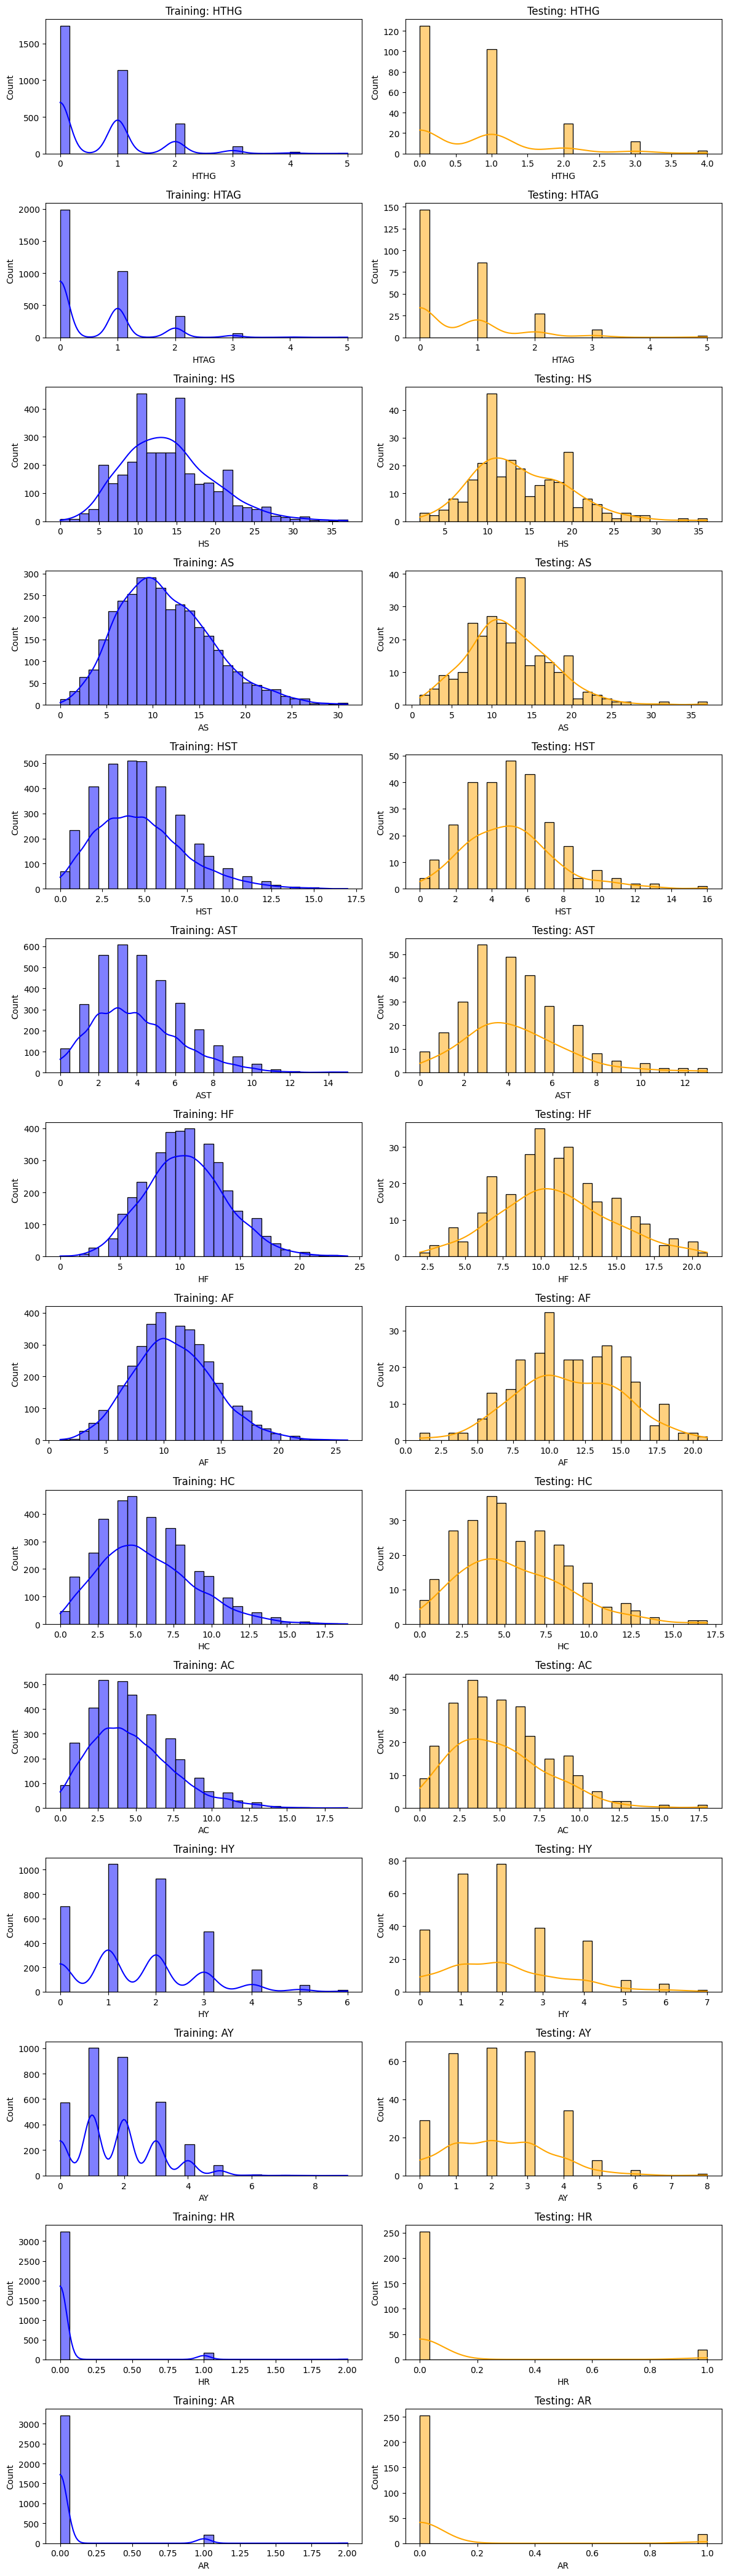

In [5]:
# then let us check to see if the data is somewhat normally skewed to determine what type of normalization to do on it
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(12, len(numeric_cols) * 3))

for i, col in enumerate(numeric_cols):
    sns.histplot(training_csv[col], bins=30, kde=True, ax=axes[i, 0], color="blue")
    axes[i, 0].set_title(f"Training: {col}")

    sns.histplot(testing_csv[col], bins=30, kde=True, ax=axes[i, 1], color="orange")
    axes[i, 1].set_title(f"Testing: {col}")

plt.tight_layout()
plt.show()

As we can see there are a couple numerical columns which act categorical, so it might be worth hot encoding them, but they are technically numerical, so I will create three different data sets I think, one where I just one hot encode all categorical columns, one where i only one hot encode the datasets that are more categorical and one where i do not one hot encode any of them, i will also change the output columns, i will do all of that now.

In [6]:
training_csv = cleaned_15_24
testing_csv = cleaned_24_25


In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

label_encoder = LabelEncoder()
# first for our training data
training_csv['FTR'] = label_encoder.fit_transform(training_csv['FTR'])  # H = 2, D = 1, A = 0
training_csv['HTR'] = label_encoder.fit_transform(training_csv['HTR'])

#then for our testing data
testing_csv['FTR'] = label_encoder.fit_transform(testing_csv['FTR'])  # H = 2, D = 1, A = 0
testing_csv['HTR'] = label_encoder.fit_transform(testing_csv['HTR'])

# get our output columns
training_output_encoded = training_csv['FTR']
training_csv = training_csv.drop(columns=['FTR'])

testing_output_encoded = testing_csv['FTR']
testing_csv = testing_csv.drop(columns=['FTR'])

# then let us change the data from the date
training_csv['year'] = training_csv['Date'].dt.year
training_csv['month'] = training_csv['Date'].dt.month
training_csv['day'] = training_csv['Date'].dt.day
training_csv['day_of_week'] = training_csv['Date'].dt.dayofweek  # 0 = Monday, 6 = Sunday
training_csv['week_of_year'] = training_csv['Date'].dt.isocalendar().week  # Week number in the year
# then let us drop the date column as we extracted the features that matter
training_csv = training_csv.drop(columns=['Date'])

# then let us do that for the testing data as well
testing_csv['year'] = testing_csv['Date'].dt.year
testing_csv['month'] = testing_csv['Date'].dt.month
testing_csv['day'] = testing_csv['Date'].dt.day
testing_csv['day_of_week'] = testing_csv['Date'].dt.dayofweek  # 0 = Monday, 6 = Sunday
testing_csv['week_of_year'] = testing_csv['Date'].dt.isocalendar().week  # Week number in the year
# then let us drop the date column as we extracted the features that matter
testing_csv = testing_csv.drop(columns=['Date'])

# then let us go extreme with one hot encoding
label_encoded_columns = ['HomeTeam', 'AwayTeam', 'Referee']
extreme_columns = ['HTHG', 'HTAG', 'HY', 'AY', 'HR', 'AR', 'year', 'day_of_week']
# then let us do less extremem one hot encoding
less_extreme_columns = ['HomeTeam', 'AwayTeam']
label_encode_less_extreme = ['Referee']

# first label encode the three columns
training_csv['HomeTeam'] = label_encoder.fit_transform(training_csv['HomeTeam'])
training_csv['AwayTeam'] = label_encoder.fit_transform(training_csv['AwayTeam'])
training_csv['Referee'] = label_encoder.fit_transform(training_csv['Referee'])

testing_csv['HomeTeam'] = label_encoder.fit_transform(testing_csv['HomeTeam'])
testing_csv['AwayTeam'] = label_encoder.fit_transform(testing_csv['AwayTeam'])
testing_csv['Referee'] = label_encoder.fit_transform(testing_csv['Referee'])

# first we do extreme
# first for the training data
extreme_training = pd.get_dummies(training_csv, columns=extreme_columns, drop_first=True)
# then we do our testing data
extreme_testing = pd.get_dummies(testing_csv, columns=extreme_columns, drop_first=True)
# then we turn everything into ints
extreme_training = extreme_training.map(lambda x: 1 if x is True else (0 if x is False else x))
extreme_testing = extreme_testing.map(lambda x: 1 if x is True else (0 if x is False else x))

# then just call it normal training and testing
normal_training = training_csv
normal_testing = testing_csv

# then we normalize the columns that are normally distributed
normalizing_columns = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC']
scaler = StandardScaler()
# extreme first
extreme_training[normalizing_columns] = scaler.fit_transform(extreme_training[normalizing_columns])
extreme_testing[normalizing_columns] = scaler.fit_transform(extreme_testing[normalizing_columns])

# the normal columns now
normal_training[normalizing_columns] = scaler.fit_transform(normal_training[normalizing_columns])
normal_testing[normalizing_columns] = scaler.fit_transform(normal_testing[normalizing_columns])


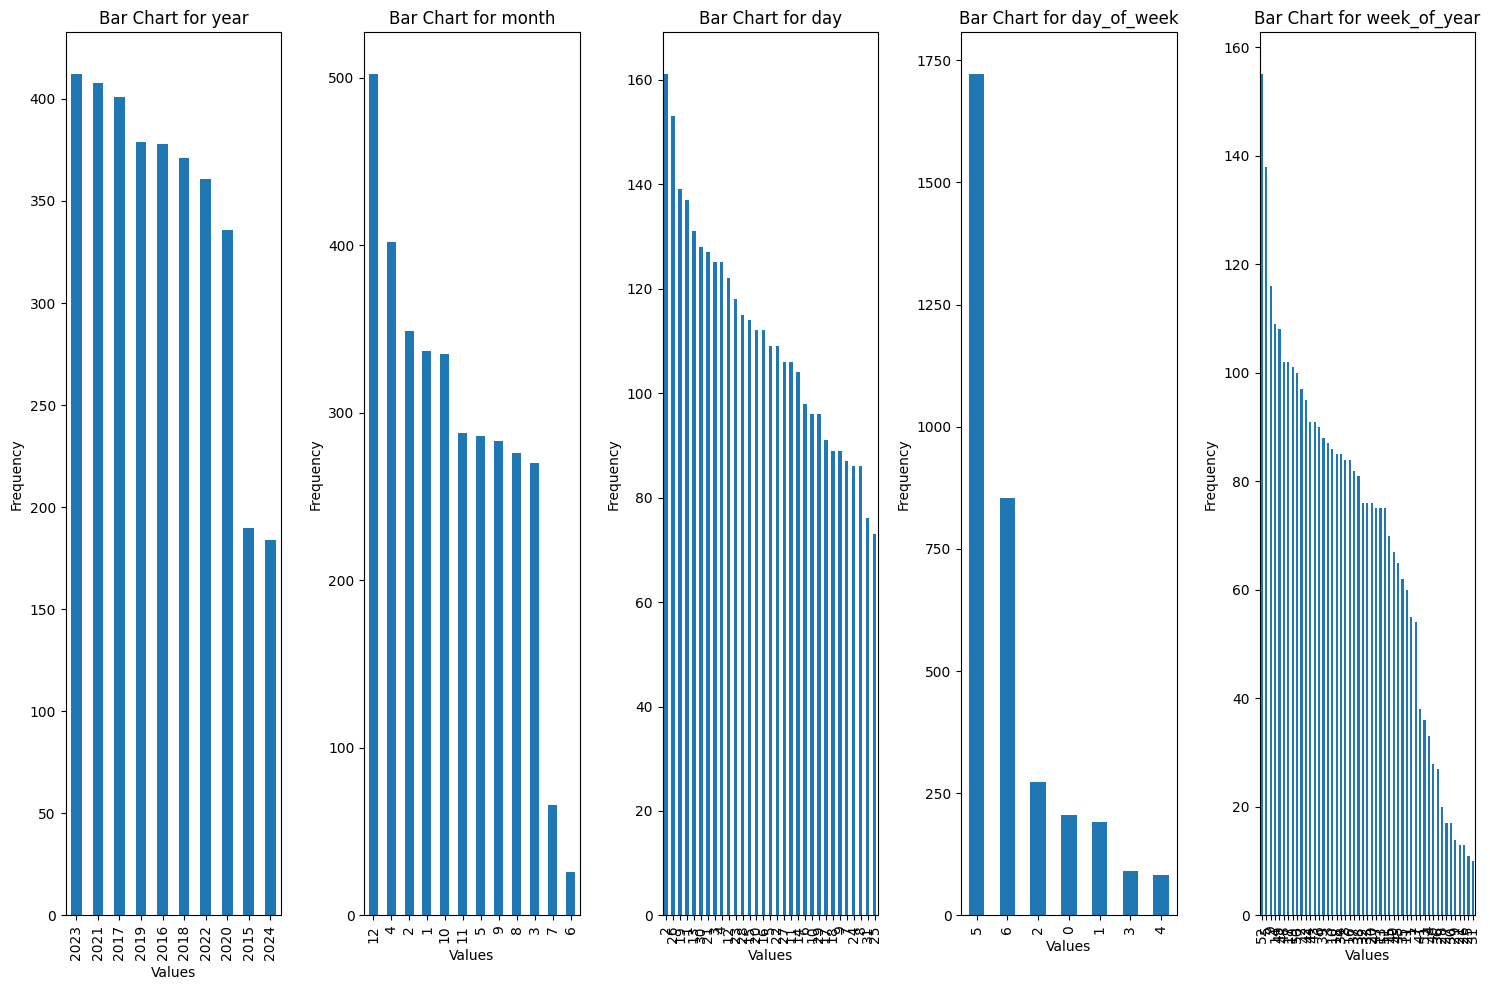

In [8]:
# let me plot some data from the new date columns to see if they are important
plt.figure(figsize=(15, 10))

# Loop through the columns you want to plot
columns_to_plot = ['year', 'month', 'day', 'day_of_week', 'week_of_year']

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(1, 5, i) 
    training_csv[col].value_counts().plot(kind='bar')
    plt.title(f'Bar Chart for {col}')
    plt.ylabel('Frequency')
    plt.xlabel('Values')

plt.tight_layout()
plt.show()

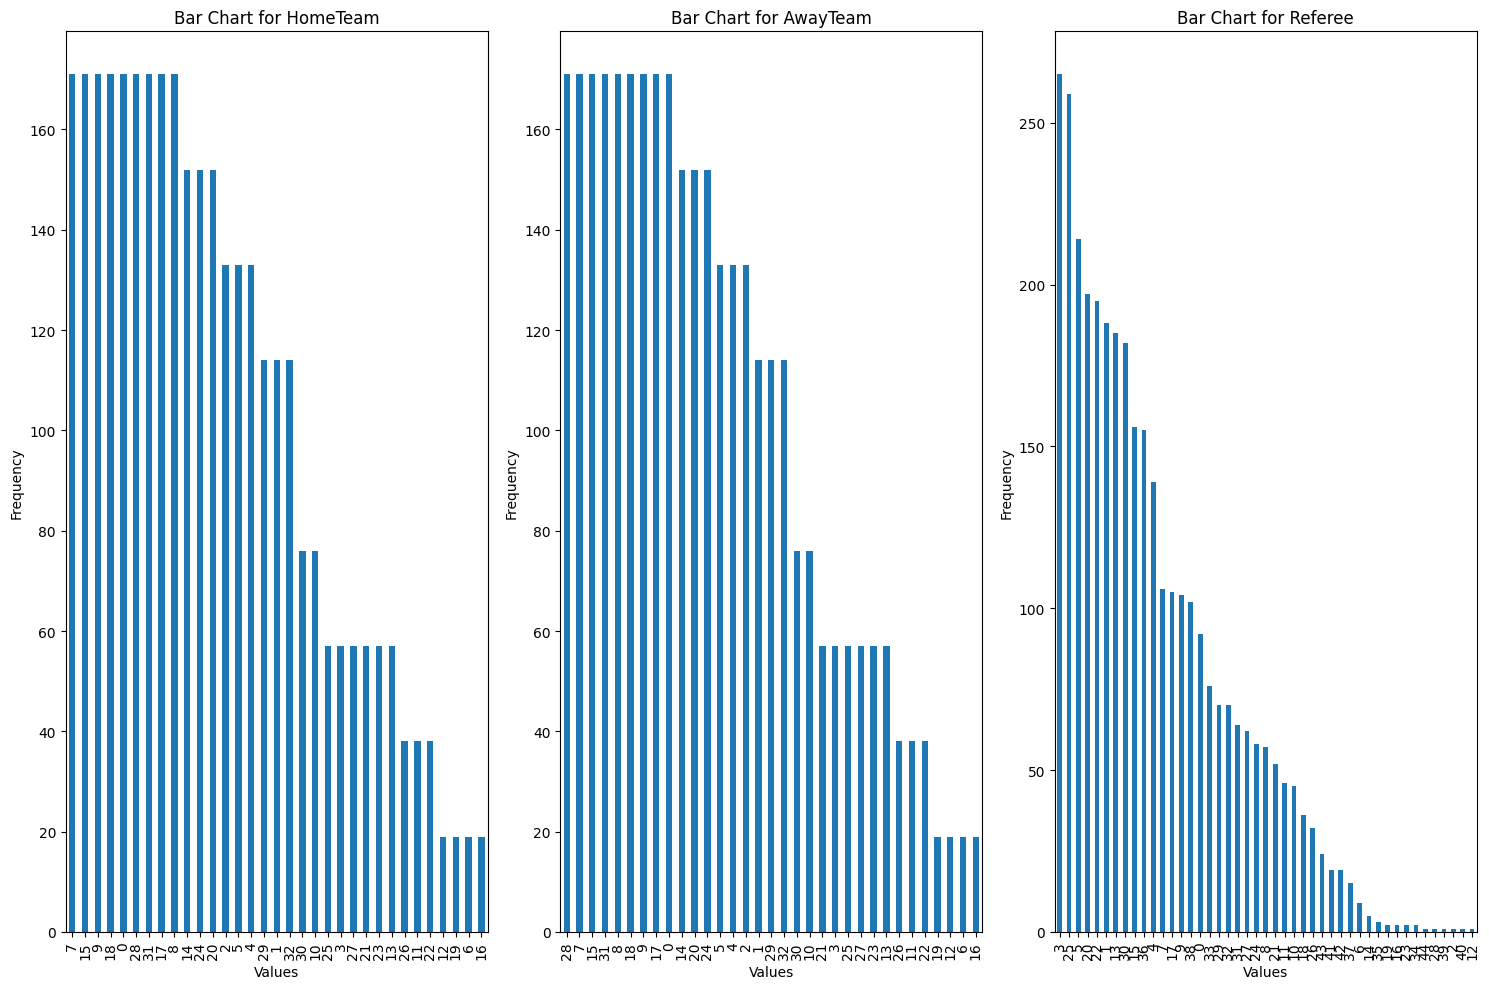

training data home team:  33
training data away team:  33
training data referee:  45
testing data home team:  20
testing data away team:  20
testing data referee:  23


In [9]:
# lets figure out if we have to one hot encode the referee and team names or if we will do label encoding
plt.figure(figsize=(15, 10))

# Loop through the columns you want to plot
columns_to_plot = ['HomeTeam', 'AwayTeam', 'Referee']

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(1, 3, i) 
    training_csv[col].value_counts().plot(kind='bar')
    plt.title(f'Bar Chart for {col}')
    plt.ylabel('Frequency')
    plt.xlabel('Values')

plt.tight_layout()
plt.show()
print("training data home team: ", training_csv['HomeTeam'].nunique())
print("training data away team: ", training_csv['AwayTeam'].nunique())
print("training data referee: ", training_csv['Referee'].nunique())

print("testing data home team: ", testing_csv['HomeTeam'].nunique())
print("testing data away team: ", testing_csv['AwayTeam'].nunique())
print("testing data referee: ", testing_csv['Referee'].nunique())

more hot encoding = linear  
less hot encoding/no hot encoding = tree based models

In [10]:
# training_output_encoded
# testing_output_encoded
# extreme_training
# extreme_testing
# normal_training
# normal_testing

from sklearn.metrics import f1_score, accuracy_score
def prediction_accuracy(y_test, final_predictions): 
    f1_weighted = f1_score(y_test, final_predictions, average='weighted')
    # print("weighted F1 Score: ", f1_weighted)

    f1_macro = f1_score(y_test, final_predictions, average='macro')
    # print("macro F1 Score: ", f1_macro)

    f1_micro = f1_score(y_test, final_predictions, average='micro')
    # print("micro F1 Score: ", f1_micro)

    f1_none = f1_score(y_test, final_predictions, average=None)
    # print("none F1 Score: ", f1_none)

    accuracy = accuracy_score(y_test, final_predictions)
    # print("accuray: ", accuracy)
    return f1_weighted, f1_macro, f1_micro, f1_none, accuracy

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier


# Linear Models
lr_test = OneVsRestClassifier(LogisticRegression(max_iter=500, solver='liblinear'))

# Linear SVM
lsvm_test = SVC(kernel='linear', decision_function_shape='ovr')

# K Nearest Neighbors
knn_test = KNeighborsClassifier(n_neighbors=5)

# Tree-based Models
dt_test = DecisionTreeClassifier()
rf_test = RandomForestClassifier(n_estimators=100)
gb_test = GradientBoostingClassifier(n_estimators=100)
gnb_test = GaussianNB()  # Naive Bayes for simplicity

# Ensemble Methods (for Linear models)
ensemble_linear_bagging = BaggingClassifier(estimator=LogisticRegression(max_iter=500, solver='liblinear'), n_estimators=50)
ensemble_linear_boosting = AdaBoostClassifier(estimator=LogisticRegression(max_iter=500, solver='liblinear'), n_estimators=50)
ensemble_linear_stacking = StackingClassifier(
    estimators=[
        ('lr', OneVsRestClassifier(LogisticRegression(max_iter=500, solver='liblinear'))),
        ('lsvm', SVC(kernel='linear', decision_function_shape='ovr'))
    ],
    final_estimator=OneVsRestClassifier(LogisticRegression(max_iter=500, solver='liblinear'))
)

# Ensemble Methods (for Tree-based models)
ensemble_tree_bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50)
ensemble_tree_boosting = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=50)
ensemble_tree_stacking = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=10)),
        ('dt', DecisionTreeClassifier())
    ],
    final_estimator=OneVsRestClassifier(LogisticRegression(max_iter=500, solver='liblinear'))
)

# Create testing models lists
testing_linear_models = [lr_test, lsvm_test, knn_test, ensemble_linear_bagging, ensemble_linear_boosting, ensemble_linear_stacking]
testing_tree_models = [dt_test, rf_test, gb_test, gnb_test, ensemble_tree_bagging, ensemble_tree_boosting, ensemble_tree_stacking]
testing_models = [lr_test, lsvm_test, knn_test, ensemble_linear_bagging, ensemble_linear_boosting, ensemble_linear_stacking, dt_test, rf_test, gb_test, gnb_test, ensemble_tree_bagging, ensemble_tree_boosting, ensemble_tree_stacking]


In [12]:
import numpy as np
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# the extreme doesn't actually work because both of the data sets, the 15-24 and the 24-25 don't have the same values so when we 
# one hot encode they do not have the same amount of columns - this might be something we fix if we have enough time

# then let us do it on the not extreme

In [109]:
# first feature selection
# Variance Threshold (Filter Method)
variance_threshold = VarianceThreshold(threshold=0.01)
fs1_train = variance_threshold.fit_transform(normal_training)
fs1_test = variance_threshold.transform(normal_testing)

In [110]:
# test this feature and try to optimize with just this feature
# the relevant arrays
weighted_arr = []
macro_arr = []
micro_arr = []
accuracy_arr = []
counter = 0
for model in testing_models:
    model.fit(fs1_train, training_output_encoded)
    y_pred = model.predict(fs1_test)
    f1_weighted, f1_macro, f1_micro, f1_none, accuracy = prediction_accuracy(testing_output_encoded, y_pred)
    weighted_arr.append((f1_weighted, counter))
    macro_arr.append((f1_macro, counter))
    micro_arr.append((f1_micro, counter))
    accuracy_arr.append((accuracy, counter))
    counter += 1


# sort and then print the model accuracy
weighted_arr.sort(key=lambda x: x[0], reverse=True)
macro_arr.sort(key=lambda x: x[0], reverse=True)
micro_arr.sort(key=lambda x: x[0], reverse=True)
accuracy_arr.sort(key=lambda x: x[0], reverse=True)

print("\nSorted Weighted Scores:", weighted_arr)
print("Sorted Macro Scores:", macro_arr)
print("Sorted Micro Scores:", micro_arr)
print("Sorted Accuracy Scores:", accuracy_arr)


Sorted Weighted Scores: [(0.5908289587926839, 7), (0.5892661254570405, 9), (0.5863767351959234, 1), (0.5729302445550875, 0), (0.5710274334033761, 8), (0.5706391572264516, 3), (0.5704332015538948, 4), (0.5666764709543066, 5), (0.5445259733257132, 10), (0.5143823163637354, 12), (0.5097699372715653, 6), (0.5062168812756528, 11), (0.3930537877689636, 2)]
Sorted Macro Scores: [(0.5566197970416237, 7), (0.5545069759031559, 9), (0.5393121693121693, 1), (0.5299694063739008, 4), (0.5247065667453717, 8), (0.5216425727057653, 0), (0.5195207425172582, 3), (0.5150588426204686, 5), (0.4977293107253225, 10), (0.4871261635967518, 6), (0.4856406075089211, 11), (0.4608920614167862, 12), (0.3698629458073617, 2)]
Sorted Micro Scores: [(0.6309963099630996, 0), (0.6309963099630996, 1), (0.6273062730627307, 3), (0.6199261992619927, 5), (0.6199261992619927, 7), (0.6088560885608856, 4), (0.6088560885608856, 8), (0.6088560885608856, 9), (0.5793357933579336, 12), (0.5756457564575646, 10), (0.5092250922509225, 6

In [125]:
all_ks = []
counter = 0
for i in range(1,24):
    # second feature selection
    univariate_selector = SelectKBest(score_func=f_classif, k=i)
    fs2_train = univariate_selector.fit_transform(normal_training, training_output_encoded)
    fs2_test = univariate_selector.transform(normal_testing)
    all_ks.append((fs2_train, fs2_test, counter))
    counter += 1

In [126]:
all_ks

[(array([[1.],
         [2.],
         [0.],
         ...,
         [0.],
         [2.],
         [0.]]),
  array([[1.],
         [1.],
         [2.],
         [0.],
         [2.],
         [2.],
         [1.],
         [2.],
         [0.],
         [0.],
         [2.],
         [1.],
         [1.],
         [2.],
         [1.],
         [2.],
         [1.],
         [2.],
         [1.],
         [2.],
         [2.],
         [2.],
         [1.],
         [1.],
         [0.],
         [1.],
         [0.],
         [2.],
         [2.],
         [0.],
         [0.],
         [1.],
         [0.],
         [2.],
         [1.],
         [2.],
         [0.],
         [1.],
         [1.],
         [2.],
         [0.],
         [0.],
         [2.],
         [0.],
         [2.],
         [2.],
         [2.],
         [1.],
         [2.],
         [0.],
         [0.],
         [2.],
         [2.],
         [2.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         

In [128]:
# test this feature and try to optimize with just this feature
# the relevant arrays
weighted_arr = []
macro_arr = []
micro_arr = []
accuracy_arr = []
for (train, test, counters) in all_ks:
    counter = 0
    for model in testing_models:
        model.fit(train, training_output_encoded)
        y_pred = model.predict(test)
        f1_weighted, f1_macro, f1_micro, f1_none, accuracy = prediction_accuracy(testing_output_encoded, y_pred)
        weighted_arr.append((f1_weighted, counter, counters))
        macro_arr.append((f1_macro, counter, counters))
        micro_arr.append((f1_micro, counter, counters))
        accuracy_arr.append((accuracy, counter, counters))
        counter += 1


# sort and then print the model accuracy
weighted_arr.sort(key=lambda x: x[0], reverse=True)
macro_arr.sort(key=lambda x: x[0], reverse=True)
micro_arr.sort(key=lambda x: x[0], reverse=True)
accuracy_arr.sort(key=lambda x: x[0], reverse=True)

print("\nSorted Weighted Scores:", weighted_arr)
print("Sorted Macro Scores:", macro_arr)
print("Sorted Micro Scores:", micro_arr)
print("Sorted Accuracy Scores:", accuracy_arr)


Sorted Weighted Scores: [(0.6283585865765932, 8, 12), (0.6204074785485234, 11, 4), (0.6147334685872248, 9, 5), (0.6146151796582465, 4, 17), (0.6138026571180788, 8, 8), (0.613553943573104, 8, 11), (0.6130771405120553, 10, 18), (0.6117266548425765, 9, 6), (0.6094568959842629, 9, 16), (0.609402482572997, 9, 17), (0.608130836830046, 2, 13), (0.6079685540387963, 10, 4), (0.6075666800443409, 8, 10), (0.6075411646973612, 11, 6), (0.6068486686170885, 9, 4), (0.6068287882500453, 4, 4), (0.6062147363409119, 8, 7), (0.6059808073019866, 2, 8), (0.6052794156602229, 7, 6), (0.605223492987384, 8, 19), (0.6046548831779319, 9, 15), (0.603471832940208, 8, 4), (0.6029827150161815, 8, 6), (0.6028294922666759, 4, 19), (0.6019263392599865, 9, 14), (0.6013279245056059, 2, 2), (0.6000141928743242, 9, 13), (0.5997507759516284, 10, 12), (0.5992408648576282, 8, 20), (0.5976209514303719, 9, 12), (0.5972030673153321, 2, 6), (0.5966582150979635, 10, 8), (0.595777346767775, 8, 18), (0.5956745798150992, 1, 14), (0.5

In [39]:
# third feature selection
all_ks_two = []
counter = 0
for i in range(1,24):
    # second feature selection
    mutual_info_selector = SelectKBest(score_func=mutual_info_classif, k=i)
    fs3_train = mutual_info_selector.fit_transform(normal_training, training_output_encoded)
    fs3_test = mutual_info_selector.transform(normal_testing)
    all_ks_two.append((fs3_train, fs3_test, counter))
    counter += 1

In [40]:
# test this feature and try to optimize with just this feature
# the relevant arrays
weighted_arr = []
macro_arr = []
micro_arr = []
accuracy_arr = []
for (train, test, counters) in all_ks_two:
    counter = 0
    for model in testing_models:
        model.fit(train, training_output_encoded)
        y_pred = model.predict(test)
        f1_weighted, f1_macro, f1_micro, f1_none, accuracy = prediction_accuracy(testing_output_encoded, y_pred)
        weighted_arr.append((f1_weighted, counter, counters))
        macro_arr.append((f1_macro, counter, counters))
        micro_arr.append((f1_micro, counter, counters))
        accuracy_arr.append((accuracy, counter, counters))
        counter += 1


# sort and then print the model accuracy
weighted_arr.sort(key=lambda x: x[0], reverse=True)
macro_arr.sort(key=lambda x: x[0], reverse=True)
micro_arr.sort(key=lambda x: x[0], reverse=True)
accuracy_arr.sort(key=lambda x: x[0], reverse=True)

print("\nSorted Weighted Scores:", weighted_arr)
print("Sorted Macro Scores:", macro_arr)
print("Sorted Micro Scores:", micro_arr)
print("Sorted Accuracy Scores:", accuracy_arr)


Sorted Weighted Scores: [(0.6334782345853968, 4, 5), (0.6204074785485234, 11, 4), (0.617477398571105, 8, 13), (0.6167534187625234, 7, 9), (0.6151751065912341, 9, 6), (0.6148494226877753, 8, 9), (0.6145566930810764, 4, 3), (0.6140783278882094, 10, 14), (0.6136768921284536, 4, 7), (0.613534824771015, 2, 5), (0.6132813864023807, 8, 16), (0.6124458319696838, 8, 12), (0.6115981378677778, 8, 7), (0.6106112894324977, 8, 18), (0.6101785753010639, 8, 10), (0.6101140117247947, 4, 6), (0.6099067632411551, 8, 8), (0.6091825010404001, 4, 12), (0.6083271013114961, 1, 12), (0.60832115541301, 1, 11), (0.6073343735694142, 10, 18), (0.6068486686170885, 9, 4), (0.6068486686170885, 9, 5), (0.6068287882500453, 4, 4), (0.6066788727641877, 10, 16), (0.6065810884179067, 10, 13), (0.6065123732296527, 9, 16), (0.6060426336094314, 9, 9), (0.6057084710403917, 8, 17), (0.6049175402398952, 11, 5), (0.6045778077728687, 1, 15), (0.6043147436903712, 9, 11), (0.6041544492744384, 9, 21), (0.6036413262362711, 9, 7), (0.

In [19]:
# fourth feature selection
lasso = LassoCV(cv=5).fit(normal_training, training_output_encoded)
mask = lasso.coef_ != 0
fs4_train = normal_training.iloc[:, mask]
fs4_test = normal_testing.iloc[:, mask]

In [20]:
# test this feature and try to optimize with just this feature
# the relevant arrays
weighted_arr = []
macro_arr = []
micro_arr = []
accuracy_arr = []
counter = 0
for model in testing_models:
    model.fit(fs4_train, training_output_encoded)
    y_pred = model.predict(fs4_test)
    f1_weighted, f1_macro, f1_micro, f1_none, accuracy = prediction_accuracy(testing_output_encoded, y_pred)
    weighted_arr.append((f1_weighted, counter))
    macro_arr.append((f1_macro, counter))
    micro_arr.append((f1_micro, counter))
    accuracy_arr.append((accuracy, counter))
    counter += 1


# sort and then print the model accuracy
weighted_arr.sort(key=lambda x: x[0], reverse=True)
macro_arr.sort(key=lambda x: x[0], reverse=True)
micro_arr.sort(key=lambda x: x[0], reverse=True)
accuracy_arr.sort(key=lambda x: x[0], reverse=True)

print("\nSorted Weighted Scores:", weighted_arr)
print("Sorted Macro Scores:", macro_arr)
print("Sorted Micro Scores:", micro_arr)
print("Sorted Accuracy Scores:", accuracy_arr)


Sorted Weighted Scores: [(0.6154842968162667, 8), (0.6041472220244948, 4), (0.5944400346207548, 10), (0.5909310257161611, 7), (0.5826988050656875, 9), (0.5737497609622966, 1), (0.567857800493825, 5), (0.5613574617264655, 0), (0.558804283208105, 3), (0.5443652712389193, 12), (0.5384258475612279, 6), (0.5128049019086995, 11), (0.39054172626142153, 2)]
Sorted Macro Scores: [(0.5827055971634284, 8), (0.5729576655725173, 4), (0.5575613546373198, 10), (0.5530394559265951, 7), (0.5473223184520741, 9), (0.519898216580681, 1), (0.5172103295956507, 6), (0.5142490786301187, 5), (0.5061605061605062, 0), (0.5036824213718128, 3), (0.4950738916256157, 12), (0.49312630042847455, 11), (0.3694187561935534, 2)]
Sorted Micro Scores: [(0.6383763837638377, 1), (0.6346863468634686, 8), (0.6273062730627307, 0), (0.6273062730627307, 5), (0.6236162361623616, 3), (0.6199261992619927, 4), (0.6199261992619927, 7), (0.6199261992619927, 10), (0.6051660516605166, 9), (0.5940959409594095, 12), (0.5350553505535055, 6)

In [33]:
# fifth feature selection
tree_model = RandomForestClassifier(n_estimators=100)
tree_model.fit(normal_training, training_output_encoded)
importances = tree_model.feature_importances_
threshold = np.median(importances)
mask = importances >= threshold
fs5_train = normal_training.iloc[:, mask]
fs5_test = normal_testing.iloc[:, mask]

In [34]:
# test this feature and try to optimize with just this feature
# the relevant arrays
weighted_arr = []
macro_arr = []
micro_arr = []
accuracy_arr = []
counter = 0
for model in testing_models:
    model.fit(fs5_train, training_output_encoded)
    y_pred = model.predict(fs5_test)
    f1_weighted, f1_macro, f1_micro, f1_none, accuracy = prediction_accuracy(testing_output_encoded, y_pred)
    weighted_arr.append((f1_weighted, counter))
    macro_arr.append((f1_macro, counter))
    micro_arr.append((f1_micro, counter))
    accuracy_arr.append((accuracy, counter))
    counter += 1


# sort and then print the model accuracy
weighted_arr.sort(key=lambda x: x[0], reverse=True)
macro_arr.sort(key=lambda x: x[0], reverse=True)
micro_arr.sort(key=lambda x: x[0], reverse=True)
accuracy_arr.sort(key=lambda x: x[0], reverse=True)

print("\nSorted Weighted Scores:", weighted_arr)
print("Sorted Macro Scores:", macro_arr)
print("Sorted Micro Scores:", micro_arr)
print("Sorted Accuracy Scores:", accuracy_arr)


Sorted Weighted Scores: [(0.6039782267080961, 9), (0.6023335119918418, 8), (0.5909558128393361, 6), (0.590844478619763, 1), (0.5899082360082097, 10), (0.5857635995714796, 11), (0.5796107144415827, 4), (0.5762204627697002, 7), (0.5658543987471805, 5), (0.5656778427614374, 12), (0.5653458383321338, 3), (0.558839720639378, 0), (0.40522648688916546, 2)]
Sorted Macro Scores: [(0.5704767381631798, 9), (0.5704500487109183, 6), (0.5672176750655326, 11), (0.5661214095010599, 8), (0.5567014792833577, 10), (0.5459487777973079, 1), (0.5391502236265087, 4), (0.5363133424658154, 7), (0.5155238673139159, 12), (0.5146384729449617, 5), (0.5126104715734732, 3), (0.5038385417489117, 0), (0.3871357289099759, 2)]
Sorted Micro Scores: [(0.6346863468634686, 1), (0.6309963099630996, 3), (0.6273062730627307, 0), (0.6273062730627307, 8), (0.6236162361623616, 5), (0.6236162361623616, 12), (0.6199261992619927, 9), (0.6162361623616236, 4), (0.6088560885608856, 7), (0.6014760147601476, 10), (0.5904059040590406, 6)

In [41]:
all_ks_three = []
counter = 0
for i in range(1,24):
    # sixth feature selection
    rfe_model = RandomForestClassifier()
    rfe_selector = RFE(rfe_model, n_features_to_select=i)
    fs6_train = rfe_selector.fit_transform(normal_training, training_output_encoded)
    fs6_test = rfe_selector.transform(normal_testing)
    all_ks_three.append((fs6_train, fs6_test, counter))
    counter += 1   

In [42]:
# test this feature and try to optimize with just this feature
# the relevant arrays
weighted_arr = []
macro_arr = []
micro_arr = []
accuracy_arr = []
for (train, test, counters) in all_ks_three:
    counter = 0
    for model in testing_models:
        model.fit(train, training_output_encoded)
        y_pred = model.predict(test)
        f1_weighted, f1_macro, f1_micro, f1_none, accuracy = prediction_accuracy(testing_output_encoded, y_pred)
        weighted_arr.append((f1_weighted, counter, counters))
        macro_arr.append((f1_macro, counter, counters))
        micro_arr.append((f1_micro, counter, counters))
        accuracy_arr.append((accuracy, counter, counters))
        counter += 1


# sort and then print the model accuracy
weighted_arr.sort(key=lambda x: x[0], reverse=True)
macro_arr.sort(key=lambda x: x[0], reverse=True)
micro_arr.sort(key=lambda x: x[0], reverse=True)
accuracy_arr.sort(key=lambda x: x[0], reverse=True)

print("\nSorted Weighted Scores:", weighted_arr)
print("Sorted Macro Scores:", macro_arr)
print("Sorted Micro Scores:", micro_arr)
print("Sorted Accuracy Scores:", accuracy_arr)


Sorted Weighted Scores: [(0.6304308210522424, 10, 6), (0.6295699867876553, 4, 21), (0.6233515096284566, 8, 10), (0.6218754080105872, 10, 8), (0.6209774532932169, 8, 8), (0.620310877958974, 8, 7), (0.6158586375801968, 7, 6), (0.6156257171345364, 10, 9), (0.6151014444936421, 9, 20), (0.6149151870685935, 7, 8), (0.6146069004530019, 9, 14), (0.6117060291751453, 8, 16), (0.6103611464527485, 9, 19), (0.610329064094827, 4, 8), (0.6100338384663385, 9, 13), (0.6099517271762085, 9, 17), (0.6089886894632781, 10, 16), (0.6080986117431542, 9, 15), (0.6079284739556357, 8, 9), (0.6057088441852161, 8, 11), (0.6053562189657289, 1, 14), (0.604922082278674, 9, 16), (0.6046595078565062, 1, 11), (0.6042184409452679, 8, 12), (0.6034663448650901, 8, 17), (0.6027182480020749, 7, 9), (0.6019168761394197, 8, 19), (0.6008333473467486, 8, 6), (0.5999717471794008, 10, 22), (0.5992258271460728, 1, 13), (0.5989192014806449, 4, 14), (0.598303666947028, 1, 8), (0.5982472324723247, 10, 10), (0.5975646350993381, 7, 7),

In [ ]:
# takes almost two hours to run, so have some free time when you run it
all_ks_four = []
counter = 0
for i in range(1,23):
    # seventh feature selection
    sfs_model = RandomForestClassifier()
    sfs_selector = SequentialFeatureSelector(sfs_model, n_features_to_select=i)
    fs7_train = sfs_selector.fit_transform(normal_training, training_output_encoded)
    fs7_test = sfs_selector.transform(normal_testing)
    all_ks_four.append((fs7_train, fs7_test, counter))
    counter += 1

ValueError: n_features_to_select must be < n_features.

In [50]:
print(all_ks_four[21])

(array([[ 2.,  1.,  0., ...,  8.,  5., 32.],
       [ 7., 27.,  2., ...,  8.,  5., 32.],
       [ 9., 29.,  0., ...,  8.,  5., 32.],
       ...,
       [16., 10.,  1., ..., 19.,  6., 20.],
       [17., 31.,  2., ..., 19.,  6., 20.],
       [23., 28.,  0., ..., 19.,  6., 20.]]), array([[13.,  8.,  0., ..., 16.,  4., 33.],
       [ 9., 11.,  0., ..., 17.,  5., 33.],
       [ 0., 19.,  1., ..., 17.,  5., 33.],
       ...,
       [17., 12.,  0., ..., 26.,  2.,  9.],
       [11., 14.,  1., ..., 26.,  2.,  9.],
       [18., 10.,  2., ..., 27.,  3.,  9.]]), 21)


In [51]:
# test this feature and try to optimize with just this feature
# the relevant arrays
weighted_arr = []
macro_arr = []
micro_arr = []
accuracy_arr = []
for (train, test, counters) in all_ks_four:
    counter = 0
    for model in testing_models:
        model.fit(train, training_output_encoded)
        y_pred = model.predict(test)
        f1_weighted, f1_macro, f1_micro, f1_none, accuracy = prediction_accuracy(testing_output_encoded, y_pred)
        weighted_arr.append((f1_weighted, counter, counters))
        macro_arr.append((f1_macro, counter, counters))
        micro_arr.append((f1_micro, counter, counters))
        accuracy_arr.append((accuracy, counter, counters))
        counter += 1


# sort and then print the model accuracy
weighted_arr.sort(key=lambda x: x[0], reverse=True)
macro_arr.sort(key=lambda x: x[0], reverse=True)
micro_arr.sort(key=lambda x: x[0], reverse=True)
accuracy_arr.sort(key=lambda x: x[0], reverse=True)

print("\nSorted Weighted Scores:", weighted_arr)
print("Sorted Macro Scores:", macro_arr)
print("Sorted Micro Scores:", micro_arr)
print("Sorted Accuracy Scores:", accuracy_arr)


Sorted Weighted Scores: [(0.6283712035272312, 8, 9), (0.6252964210461339, 7, 8), (0.6159625961479149, 8, 19), (0.6150080437566274, 8, 21), (0.6141776563124002, 9, 20), (0.6126782591868941, 7, 9), (0.6121094846113296, 4, 9), (0.6117256014018785, 4, 11), (0.6116846413086969, 7, 10), (0.6111931355401449, 4, 10), (0.6085532203861455, 10, 13), (0.6083311684264086, 9, 15), (0.6081053426178185, 8, 10), (0.6074981119905438, 8, 17), (0.6062922406070479, 6, 7), (0.6059265393116626, 10, 19), (0.605576305357713, 1, 16), (0.6054922555495147, 4, 7), (0.6051814911454554, 9, 17), (0.6050903728763507, 8, 2), (0.6045855467842605, 8, 14), (0.6033004354404277, 10, 10), (0.6029116864936653, 9, 21), (0.6020049534734477, 1, 19), (0.6018859480335009, 10, 9), (0.6018535259690024, 4, 20), (0.6015658586283696, 4, 18), (0.601351762301347, 9, 19), (0.6008078996300958, 1, 13), (0.6007042384760396, 8, 15), (0.6005353425787004, 1, 11), (0.6004853457029684, 11, 9), (0.6003388583604488, 8, 7), (0.6000073711390866, 10,

In [1]:
all_ks_five = []
counter = 0
for i in range(1,24):
# first feature extraction
    pca_model = PCA(n_components=i)
    fe1_train = pca_model.fit_transform(normal_training)
    fe1_test = pca_model.transform(normal_testing)
    all_ks_five.append((fe1_train, fe1_test, counter))
    counter += 1
    

NameError: name 'PCA' is not defined

In [ ]:
# test this feature and try to optimize with just this feature
# the relevant arrays
weighted_arr = []
macro_arr = []
micro_arr = []
accuracy_arr = []
for (train, test, counters) in all_ks_five:
    counter = 0
    for model in testing_models:
        model.fit(train, training_output_encoded)
        y_pred = model.predict(test)
        f1_weighted, f1_macro, f1_micro, f1_none, accuracy = prediction_accuracy(testing_output_encoded, y_pred)
        weighted_arr.append((f1_weighted, counter, counters))
        macro_arr.append((f1_macro, counter, counters))
        micro_arr.append((f1_micro, counter, counters))
        accuracy_arr.append((accuracy, counter, counters))
        counter += 1


# sort and then print the model accuracy
weighted_arr.sort(key=lambda x: x[0], reverse=True)
macro_arr.sort(key=lambda x: x[0], reverse=True)
micro_arr.sort(key=lambda x: x[0], reverse=True)
accuracy_arr.sort(key=lambda x: x[0], reverse=True)

print("\nSorted Weighted Scores:", weighted_arr)
print("Sorted Macro Scores:", macro_arr)
print("Sorted Micro Scores:", micro_arr)
print("Sorted Accuracy Scores:", accuracy_arr)

In [ ]:
# second feature extraction
lda_model = LinearDiscriminantAnalysis(n_components=1)
fe2_train = lda_model.fit_transform(normal_training, training_output_encoded)
fe2_test = lda_model.transform(normal_testing)

In [73]:
feature_transformations_normal = [
    (normal_training, normal_testing, 1),
    (fs1_train, fs1_test, 2),  # Variance Threshold
    (fs2_train, fs2_test, 3),  # SelectKBest with f_classif
    (fs3_train, fs3_test, 4),  # SelectKBest with mutual_info_classif
    (fs4_train, fs4_test, 5),  # LassoCV
    (fs5_train, fs5_test, 6),  # Random Forest feature importances
    (fs6_train, fs6_test, 7),  # RFE with Random Forest
    (fs7_train, fs7_test, 8),  # Sequential Feature Selector with Random Forest
    (fe1_train, fe1_test, 9),  # PCA
    (fe2_train, fe2_test, 10),  # LDA
]

In [84]:
# the relevant arrays
weighted_arr = []
macro_arr = []
micro_arr = []
accuracy_arr = []
for (x_train, x_test, count_feat) in feature_transformations_normal:
    counter = 0
    for model in testing_models:
        model.fit(x_train, training_output_encoded)
        y_pred = model.predict(x_test)
        f1_weighted, f1_macro, f1_micro, f1_none, accuracy = prediction_accuracy(testing_output_encoded, y_pred)
        weighted_arr.append((f1_weighted, counter, count_feat))
        macro_arr.append((f1_macro, counter, count_feat))
        micro_arr.append((f1_micro, counter, count_feat))
        accuracy_arr.append((accuracy, counter, count_feat))
        counter += 1


# sort and then print the model accuracy
weighted_arr.sort(key=lambda x: x[0], reverse=True)
macro_arr.sort(key=lambda x: x[0], reverse=True)
micro_arr.sort(key=lambda x: x[0], reverse=True)
accuracy_arr.sort(key=lambda x: x[0], reverse=True)

print("\nSorted Weighted Scores:", weighted_arr)
print("Sorted Macro Scores:", macro_arr)
print("Sorted Micro Scores:", micro_arr)
print("Sorted Accuracy Scores:", accuracy_arr)


Sorted Weighted Scores: [(0.6204074785485234, 11, 3), (0.6204074785485234, 11, 4), (0.6178023997610941, 10, 5), (0.6104916352017776, 8, 5), (0.6085229668904726, 7, 3), (0.6068486686170885, 9, 3), (0.6068486686170885, 9, 4), (0.6068287882500453, 4, 3), (0.6068287882500453, 4, 4), (0.6055396057707596, 10, 4), (0.6048516831535653, 7, 6), (0.6041472220244948, 4, 5), (0.6039782267080961, 9, 6), (0.603471832940208, 8, 3), (0.603471832940208, 8, 4), (0.6023335119918418, 8, 6), (0.6004449025568599, 1, 10), (0.5981461545963737, 10, 6), (0.5965791796617657, 8, 10), (0.5946494817400875, 9, 10), (0.5935124299083235, 1, 3), (0.5935124299083235, 1, 4), (0.5926123089520833, 7, 4), (0.591181906098754, 6, 6), (0.5910756997962657, 10, 2), (0.590844478619763, 1, 6), (0.5904019117824197, 4, 10), (0.5899938745086778, 7, 8), (0.5892661254570405, 9, 1), (0.5892661254570405, 9, 2), (0.5879566440133859, 5, 10), (0.5866082098791527, 11, 8), (0.5863767351959234, 1, 1), (0.5863767351959234, 1, 2), (0.58523582529